# 🖇️**Sequential Workflows in LangGraph**

## ⭐**01 $\rightarrow$ Simple Graph Workflow**

### ⭕**a. $\rightarrow$ BMI workflow**

In [10]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# -----------------------------
# Define the structure of the state
# -----------------------------
class BMIstate(TypedDict):
    weight_kg: float   # User's weight in kilograms
    height_m: float    # User's height in meters
    bmi: float         # Calculated Body Mass Index
    category: str      # BMI category (Underweight, Normal, etc.)

# -----------------------------
# Step 1: Calculate BMI from weight and height
# -----------------------------
def calculate_bmi(state: BMIstate) -> BMIstate:
    """
    Calculate the Body Mass Index (BMI) based on the provided weight and height.

    Args:
        state (BMIstate): The current state containing weight and height.

    Returns:
        BMIstate: Updated state with the calculated BMI value.
    """
    weight = state['weight_kg']
    height = state['height_m']
    bmi = weight / (height ** 2)

    # Store the rounded BMI in the state
    state['bmi'] = round(bmi, 2)

    return state

# -----------------------------
# Step 2: Categorize the BMI value
# -----------------------------
def label_bmi(state: BMIstate) -> BMIstate:
    """
    Assign a category to the BMI value (e.g., Underweight, Normal, Overweight, Obesity).

    Args:
        state (BMIstate): The current state with the BMI value.

    Returns:
        BMIstate: Updated state with the BMI category.
    """
    bmi = state['bmi']
    
    if bmi < 18.5:
        state['category'] = 'Underweight'
    elif 18.5 <= bmi < 24.9:
        state['category'] = 'Normal weight'
    elif 25 <= bmi < 29.9:
        state['category'] = 'Overweight'
    else:
        state['category'] = 'Obesity'

    return state

# -----------------------------
# Build the LangGraph workflow
# -----------------------------
# Initialize the graph with the defined state type
graph = StateGraph(BMIstate)

# Register the function nodes
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)

# Define the flow between the nodes
graph.add_edge(START, 'calculate_bmi')         # Start → calculate_bmi
graph.add_edge('calculate_bmi', 'label_bmi')   # calculate_bmi → label_bmi
graph.add_edge('label_bmi', END)               # label_bmi → End

# Compile the graph into an executable workflow
bmi_workflow = graph.compile()

# -----------------------------
# Execute the graph
# -----------------------------
initial_state = {
    'weight_kg': 89,
    'height_m': 1.81
}

# Run the workflow with the input state
final_state = bmi_workflow.invoke(initial_state)

# Display the result
print(final_state)

{'weight_kg': 89, 'height_m': 1.81, 'bmi': 27.17, 'category': 'Overweight'}


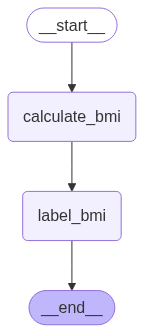

In [11]:
from IPython.display import Image
Image(bmi_workflow.get_graph().draw_mermaid_png())

### ⭕**b. $\rightarrow$ Password Strength**

In [15]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# -----------------------------
# Define the state
# -----------------------------
class PasswordState(TypedDict):
    password: str
    strength: str
    suggestions: str

# -----------------------------
# Step 1: Evaluate Password Strength
# -----------------------------
def evaluate_strength(state: PasswordState) -> PasswordState:
    password = state["password"]
    
    # Basic rules
    length = len(password) >= 8
    has_upper = any(c.isupper() for c in password)
    has_lower = any(c.islower() for c in password)
    has_digit = any(c.isdigit() for c in password)
    has_special = any(c in "!@#$%^&*()-_+=" for c in password)

    score = sum([length, has_upper, has_lower, has_digit, has_special])
    
    if score == 5:
        state["strength"] = "Strong"
    elif score >= 3:
        state["strength"] = "Moderate"
    else:
        state["strength"] = "Weak"
    
    return state

# -----------------------------
# Step 2: Suggest Improvements
# -----------------------------
def suggest_improvements(state: PasswordState) -> PasswordState:
    if state["strength"] == "Strong":
        state["suggestions"] = "No suggestions. Your password is strong! ✅"
        return state

    password = state["password"]
    suggestions = []

    if len(password) < 8:
        suggestions.append("Use at least 8 characters.")
    if not any(c.isupper() for c in password):
        suggestions.append("Add an uppercase letter.")
    if not any(c.islower() for c in password):
        suggestions.append("Add a lowercase letter.")
    if not any(c.isdigit() for c in password):
        suggestions.append("Include a number.")
    if not any(c in "!@#$%^&*()-_+=" for c in password):
        suggestions.append("Include a special character (e.g., !@#$).")

    state["suggestions"] = " ".join(suggestions)
    return state

# -----------------------------
# Build the LangGraph workflow
# -----------------------------
graph = StateGraph(PasswordState)
graph.add_node("evaluate_strength", evaluate_strength)
graph.add_node("suggest_improvements", suggest_improvements)

# Define edges
graph.add_edge(START, "evaluate_strength")
graph.add_edge("evaluate_strength", "suggest_improvements")
graph.add_edge("suggest_improvements", END)

pass_workflow = graph.compile()

# -----------------------------
# Run the workflow
# -----------------------------
initial_state = {
    "password": "paSS123@"
}

final_state = pass_workflow.invoke(initial_state)
print(final_state)

{'password': 'paSS123@', 'strength': 'Strong', 'suggestions': 'No suggestions. Your password is strong! ✅'}


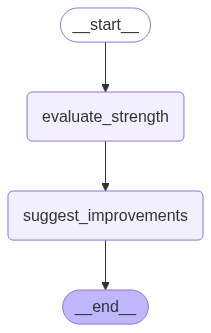

In [14]:
from IPython.display import Image
Image(pass_workflow.get_graph().draw_mermaid_png())

### ⭕**c. $\rightarrow$ Job Application Screener**

**Nodes:**

1. `validate_input`
2. `score_experience`
3. `score_skills`
4. `evaluate_fit`
5. `generate_feedback`

In [17]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List

# -----------------------------
# Define the state
# -----------------------------
class ApplicantState(TypedDict):
    name: str
    years_experience: int
    skills: List[str]
    desired_role: str
    experience_score: int
    skills_score: int
    fit: str
    feedback: str

# -----------------------------
# Step 1: Validate Input
# -----------------------------
def validate_input(state: ApplicantState) -> ApplicantState:
    if not state.get("name") or state["years_experience"] < 0:
        raise ValueError("Invalid input: Name required and experience must be non-negative.")
    return state

# -----------------------------
# Step 2: Score Experience
# -----------------------------
def score_experience(state: ApplicantState) -> ApplicantState:
    exp = state["years_experience"]
    if exp >= 5:
        state["experience_score"] = 5
    elif exp >= 3:
        state["experience_score"] = 3
    else:
        state["experience_score"] = 1
    return state

# -----------------------------
# Step 3: Score Skills
# -----------------------------
REQUIRED_SKILLS = {
    "Data Scientist": ["Python", "Pandas", "Machine Learning", "SQL"],
    "Frontend Developer": ["HTML", "CSS", "JavaScript", "React"],
    "Backend Developer": ["Python", "Django", "APIs", "Databases"]
}

def score_skills(state: ApplicantState) -> ApplicantState:
    role = state["desired_role"]
    applicant_skills = set(skill.lower() for skill in state["skills"])
    required = set(skill.lower() for skill in REQUIRED_SKILLS.get(role, []))

    matched = len(applicant_skills.intersection(required))
    state["skills_score"] = matched
    return state

# -----------------------------
# Step 4: Evaluate Fit
# -----------------------------
def evaluate_fit(state: ApplicantState) -> ApplicantState:
    exp = state["experience_score"]
    skill = state["skills_score"]

    if exp >= 5 and skill >= 3:
        state["fit"] = "Excellent"
    elif exp >= 3 and skill >= 2:
        state["fit"] = "Good"
    else:
        state["fit"] = "Poor"
    return state

# -----------------------------
# Step 5: Generate Feedback
# -----------------------------
def generate_feedback(state: ApplicantState) -> ApplicantState:
    feedback = f"{state['name']}, you applied for a {state['desired_role']} role. "
    if state["fit"] == "Excellent":
        feedback += "✅ Great fit! You're highly qualified."
    elif state["fit"] == "Good":
        feedback += "👍 You're a decent fit. Consider improving a few areas."
    else:
        feedback += "⚠️ You're currently not a great match. Consider gaining more experience or skills."
    state["feedback"] = feedback
    return state

# -----------------------------
# Build the Graph
# -----------------------------
graph = StateGraph(ApplicantState)

graph.add_node("validate_input", validate_input)
graph.add_node("score_experience", score_experience)
graph.add_node("score_skills", score_skills)
graph.add_node("evaluate_fit", evaluate_fit)
graph.add_node("generate_feedback", generate_feedback)

# Define edges (sequential)
graph.add_edge(START, "validate_input")
graph.add_edge("validate_input", "score_experience")
graph.add_edge("score_experience", "score_skills")
graph.add_edge("score_skills", "evaluate_fit")
graph.add_edge("evaluate_fit", "generate_feedback")
graph.add_edge("generate_feedback", END)

job_workflow = graph.compile()

# -----------------------------
# Run the Workflow
# -----------------------------
input_state = {
    "name": "Alice",
    "years_experience": 4,
    "skills": ["Python", "SQL", "Machine Learning", "Excel"],
    "desired_role": "Data Scientist"
}

result = job_workflow.invoke(input_state)
print(result)

{'name': 'Alice', 'years_experience': 4, 'skills': ['Python', 'SQL', 'Machine Learning', 'Excel'], 'desired_role': 'Data Scientist', 'experience_score': 3, 'skills_score': 3, 'fit': 'Good', 'feedback': "Alice, you applied for a Data Scientist role. 👍 You're a decent fit. Consider improving a few areas."}


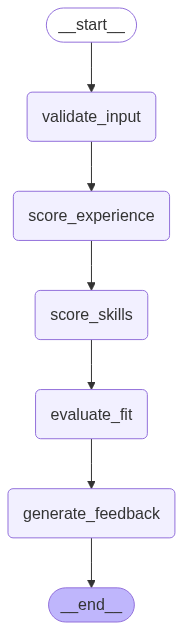

In [18]:
from IPython.display import Image
Image(job_workflow.get_graph().draw_mermaid_png())

## ⭐**02 $\rightarrow$ Simple LLM Workflow**

In [4]:
# -----------------------------
# Import Required Libraries
# -----------------------------
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# -----------------------------
# Initialize the LLM Model
# -----------------------------
model = ChatGroq(
    model="llama-3.1-8b-instant",  # Groq-hosted LLaMA 3.1 model
    temperature=0.7,               # Controls randomness of output
    max_tokens=100                 # Limits the number of tokens in output
)

# -----------------------------
# Define State Structure
# -----------------------------
class LLMState(TypedDict):
    question: str
    answer: str

# -----------------------------
# Node Function: LLM QA
# -----------------------------
def llm_qa(state: LLMState) -> LLMState:
    """
    A simple function to send the question to the LLM
    and update the answer in the state.
    """

    # Extract the question from the input state
    question = state["question"]

    # Create a prompt using the question
    prompt = f'Answer the following question: {question}'

    # Invoke the LLM and get the answer
    answer = model.invoke(prompt).content

    # Update the answer in the state
    state["answer"] = answer

    return state

# -----------------------------
# Build the LangGraph Workflow
# -----------------------------
# Initialize the state graph with our custom state
graph = StateGraph(LLMState)

# Add the LLM QA node
graph.add_node("llm_qa", llm_qa)

# Define the edges: START -> llm_qa -> END
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)

# Compile the workflow into an executable graph
llm_workflow = graph.compile()

# -----------------------------
# Execute the Workflow
# -----------------------------
# Define initial input with a question
initial_state = {
    "question": "How long does it take for light to travel from the Sun to Earth?"
}

# Run the workflow and get the final state
final_state = llm_workflow.invoke(initial_state)

# -----------------------------
# Display the Result
# -----------------------------
print(final_state['answer'])

The time it takes for light to travel from the Sun to Earth is approximately 8 minutes and 20 seconds. This is due to the Sun being about 93 million miles (149.6 million kilometers) away from Earth on average.

To calculate this time, we can use the speed of light, which is approximately 186,282 miles per second (299,792 kilometers per second). 

We can use the following formula: 

Time = Distance / Speed

Plugging in the values,


## ⭐**03 $\rightarrow$ Prompt Chaining**

In [10]:
# =============================
# Section: Import Required Libraries
# =============================
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict
from dotenv import load_dotenv

# Load environment variables (e.g., GROQ_API_KEY) from a .env file
load_dotenv()

# =============================
# Section: Initialize the LLM Model
# =============================
model = ChatGroq(
    model="llama-3.1-8b-instant",  # Use Groq-hosted LLaMA 3.1 model
    temperature=0.7,               # Controls randomness/creativity
    max_tokens=100                 # Limits length of output
)

# =============================
# Section: Define State Schema
# =============================
class BlogState(TypedDict):
    title: str
    outline: str
    content: str

# =============================
# Section: Node - Create Outline
# =============================
def create_outline(state: BlogState) -> BlogState:
    # Fetch blog title from state
    title = state['title']

    # Prompt LLM to generate an outline
    prompt = f'Generate a detailed outline for a blog post titled: {title}'
    outline = model.invoke(prompt).content

    # Update state with the generated outline
    state['outline'] = outline
    return state

# =============================
# Section: Node - Create Blog Content
# =============================
def create_blog(state: BlogState) -> BlogState:
    # Fetch title and outline from state
    title = state['title']
    outline = state['outline']

    # Prompt LLM to generate full blog post content
    prompt = f'Write a detailed blog post based on the following outline: {outline}'
    content = model.invoke(prompt).content

    # Update state with the generated content
    state['content'] = content
    return state

# =============================
# Section: Build Workflow Graph
# =============================
graph = StateGraph(BlogState)

# Register Nodes
graph.add_node('create_outline', create_outline)
graph.add_node('create_blog', create_blog)

# Register Edges (define workflow sequence)
graph.add_edge(START, 'create_outline')        # Start → create_outline
graph.add_edge('create_outline', 'create_blog')# create_outline → create_blog
graph.add_edge('create_blog', END)             # create_blog → End

# Compile the graph into an executable workflow
blog_workflow = graph.compile()

# =============================
# Section: Run the Workflow
# =============================
# Define the initial state (input to the graph)
initial_state = {
    'title': 'The Future of AI in Everyday Life'
}

# Invoke the graph with the initial input
final_state = blog_workflow.invoke(initial_state)

# =============================
# Section: Output Final Result
# =============================
# Print the resulting state containing title, outline, and blog content
print(final_state)

{'title': 'The Future of AI in Everyday Life', 'outline': '**I. Introduction**\n\n- Subheading: "Embracing the Rise of Artificial Intelligence"\n- Brief overview of the current state of AI technology and its growing presence in everyday life\n- Thesis statement: As AI technology continues to advance, we can expect to see its increased integration into various aspects of our daily lives, transforming the way we live, work, and interact with one another.\n\n**II. AI in the Home**\n\n- Subheading: "Smart Homes and the Rise of Voice Assistants', 'content': '**Embracing the Rise of Artificial Intelligence: A New Era of Transformation**\n\n**I. Introduction**\n\n**Embracing the Rise of Artificial Intelligence**\n\nArtificial intelligence (AI) has become an integral part of our daily lives, transforming the way we live, work, and interact with one another. From virtual assistants to self-driving cars, AI technology has made tremendous strides in recent years, and its presence is only expected